## Purpose

This notebook implements an automated fraud inquiry analysis pipeline that processes customer fraud complaints to extract structured information, assess risk levels, and prioritize cases for review. The system uses Large Language Models (LLMs) combined with business logic to transform unstructured text documents into actionable intelligence for fraud investigation teams.

Built using LangGraph, the pipeline is designed for easy extensibility and future enhancements. While the current implementation follows a straightforward linear workflow, the LangGraph framework enables seamless addition of complex features.

The notebook serves as both a practical tool for fraud analysts and a demonstration of how AI can streamline the initial triage process of fraud cases, reducing manual workload while ensuring critical cases receive appropriate attention.

## Use Cases

### Financial Institution Fraud Departments
- Scenario: A bank receives hundreds of fraud complaints daily via email, phone transcripts, and web forms.
- Application: Automatically categorize incoming reports, identify high-priority cases (large monetary losses, urgent language), and route them to appropriate specialists
- Benefit: Reduces initial triage time from hours to minutes, ensures critical cases aren't missed in high-volume periods

### Customer Service Operations
- Scenario: Multi-channel customer complaints about fraudulent activities need consistent handling regardless of source.
- Application: Process complaints from various channels (chat logs, emails, call transcripts) into standardized format for case management systems
- Benefit: Ensures consistent service quality, reduces response time for urgent cases

## Key Components

### Core Architecture
- Unified State Management: Single FraudState Pydantic model that tracks all case information throughout the processing pipeline
- LangGraph Workflow: Structured processing pipeline with four sequential nodes: ingestion → analysis → scoring → reporting
- Single LLM Analysis: Comprehensive extraction of all relevant information in one API call for efficiency and consistency

### Processing Pipeline
- Document Ingestion: Loads fraud inquiry text files from the file system
- AI-Powered Analysis: Uses GPT-4o-mini to extract structured information including:
    Case summary
    Fraud categories and subcategories
    Attack channels/vectors
    Monetary impact
    Urgency indicators
- Risk Assessment: Applies business rules to determine risk scores and human review requirements
- Report Generation: Produces clean, structured output suitable for downstream systems

### Output Features
- Results saved as both JSON (for systems integration) and CSV (for human analysis)
- Automatic flagging of cases requiring human review

## Conclusion

This fraud analysis pipeline demonstrates how AI can effectively automate the initial triage of fraud cases. The system combines LLM-powered information extraction with structured business logic to transform unstructured complaints into actionable insights, reducing manual processing time while ensuring critical cases receive immediate attention. 

## 1. Setup & Dependencies

In [1]:
# !pip install pydantic langchain_openai python-dotenv langgraph
import os
from dotenv import load_dotenv
from typing import Optional, List, Dict, Any, Literal
from pydantic import BaseModel, Field
from pathlib import Path
from datetime import datetime
import json, csv, glob

# Load environment variables
load_dotenv()

# Initialize LLM
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

## 2. FraudData Schema
Define the state model for fraud analysis. This model tracks all relevant information for each case as it moves through the pipeline.

In [2]:
class FraudAnalysisState(BaseModel):
    """Single comprehensive state model for fraud analysis"""
    
    # File and document info
    source_path: Optional[str] = None
    file_path: Optional[str] = None
    raw_text: Optional[str] = None
    
    # LLM extracted fields
    summary: Optional[str] = Field(default=None, description="Brief summary of the fraud inquiry")
    categories: List[str] = Field(default_factory=lambda: ["Unknown"], description="Top-level fraud categories")
    subcategories: List[str] = Field(default_factory=lambda: ["Unknown"], description="Specific fraud types")
    channels: List[str] = Field(default_factory=lambda: ["Unknown"], description="Communication/attack vectors")
    monetary_impact: Optional[float] = Field(default=None, description="Estimated monetary impact")
    urgency: bool = Field(default=False, description="Whether case requires urgent attention base on the time sensitivity")
    extraction_reason: Optional[str] = Field(default=None, description="Explanation for classification")
    
    # Computed fields
    risk_score: Literal["Low", "Medium", "High"] = "Low"
    needs_human_review: bool = False
    processing_timestamp: str = ""


## 3. Core Functions

In [3]:
def document_ingestion(state: FraudAnalysisState) -> FraudAnalysisState:
    """Load document content from file"""
    path = Path(state.file_path)
    with open(path, 'r', encoding='utf-8') as f:
        state.raw_text = f.read()
    return state

def comprehensive_analysis(state: FraudAnalysisState) -> FraudAnalysisState:
    """Single LLM call to extract all information at once"""
    prompt = f'''
You are an expert fraud analyst. Analyze the following fraud inquiry document and extract ALL the requested information in a single response.

IMPORTANT: Return your response as a valid JSON object with these exact fields:

{{
  "summary": "Brief 1-2 sentence summary of the inquiry",
  "categories": ["List of top-level fraud categories"],
  "subcategories": ["List of specific fraud types"],
  "channels": ["List of communication/attack vectors"],
  "monetary_impact": numeric_value_or_null,
  "urgency": true_or_false,
  "extraction_reason": "Short explanation for your classifications"
}}

Guidelines:
- For categories, subcategories, channels: Use "Unknown" if you cannot determine, "Ambiguous" if unclear
- For urgency: True if client language indicates immediate need (words like "immediately", "ASAP", "help now", etc.)
- For monetary_impact: Extract numeric value if mentioned, otherwise null
- Keep extraction_reason concise (1-2 sentences max)

Examples:

EXAMPLE 1:
Document: "I need help immediately! Someone stole $2,500 from my account through a fake bank email!"
Response:
{{
  "summary": "Customer fell victim to phishing email impersonating bank, lost $2,500",
  "categories": ["Digital Fraud", "Identity Fraud"],
  "subcategories": ["Phishing", "Account Takeover"],
  "channels": ["Email", "Online Banking"],
  "monetary_impact": 2500.0,
  "urgency": true,
  "extraction_reason": "Clear phishing case with explicit urgency request and significant monetary loss"
}}

EXAMPLE 2:
Document: "I noticed a $15 charge I don't recognize, can you look into it when possible?"
Response:
{{
  "summary": "Customer reporting unrecognized $15 charge, non-urgent inquiry",
  "categories": ["Payment Fraud"],
  "subcategories": ["Unauthorized Transaction"],
  "channels": ["Unknown"],
  "monetary_impact": 15.0,
  "urgency": false,
  "extraction_reason": "Small unauthorized charge, no urgency indicated by customer"
}}

Now analyze this document:
{state.raw_text}
'''
    response = llm.invoke(prompt)
    try:
        result = json.loads(response.content.strip())
        state.summary = result.get("summary")
        state.categories = result.get("categories", ["Unknown"])
        state.subcategories = result.get("subcategories", ["Unknown"])
        state.channels = result.get("channels", ["Unknown"])
        state.monetary_impact = result.get("monetary_impact")
        state.urgency = result.get("urgency", False)
        state.extraction_reason = result.get("extraction_reason")
        state.processing_timestamp = datetime.now().isoformat()
    except json.JSONDecodeError:
        state.extraction_reason = 'Failed to parse LLM response'
        state.needs_human_review = True
    return state

def apply_business_rules(state: FraudAnalysisState) -> FraudAnalysisState:
    """Apply business logic for risk scoring and human review flags"""
    if state.monetary_impact and state.monetary_impact > 10000:
        state.risk_score = 'High'
    elif state.urgency:
        state.risk_score = 'Medium'
    else:
        state.risk_score = 'Low'
    has_unknowns = (
        any(c == 'Unknown' for c in state.categories) or
        any(sc == 'Unknown' for sc in state.subcategories) or
        any(ch == 'Unknown' for ch in state.channels)
    )
    state.needs_human_review = (
        has_unknowns or 
        state.risk_score == 'High' or
        not state.extraction_reason
    )
    return state

def generate_report(state: FraudAnalysisState) -> Dict[str, Any]:
    """Generate final report, removing internal fields"""
    output = state.model_dump()
    for field in ['raw_text', 'file_path']:
        output.pop(field, None)
    return output

## 4. LangGraph Workflow Definition

In [4]:
from langgraph.graph import StateGraph, START, END

# Graph definition
fraud_graph = StateGraph(FraudAnalysisState)

# Graph nodes
fraud_graph.add_node('ingest', document_ingestion)
fraud_graph.add_node('analyze', comprehensive_analysis)
fraud_graph.add_node('apply_rules', apply_business_rules)
fraud_graph.add_node('report', generate_report)

# Graph edges
fraud_graph.add_edge(START, 'ingest')
fraud_graph.add_edge('ingest', 'analyze')
fraud_graph.add_edge('analyze', 'apply_rules')
fraud_graph.add_edge('apply_rules', 'report')
fraud_graph.add_edge('report', END)

# Graph compilation
fraud_graph = fraud_graph.compile()

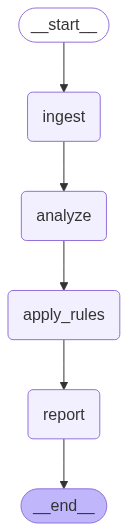

In [5]:
from IPython.display import Image, display

# Create and display the graph
display(Image(fraud_graph.get_graph(xray=True).draw_mermaid_png()))

## 5. Processing Functions 

In [6]:
def run_fraud_analysis(file_path: str) -> Dict[str, Any]:
    """Run fraud analysis on a single file."""
    state = FraudAnalysisState(source_path=os.path.basename(file_path), file_path=file_path)
    result = fraud_graph.invoke(state)
    return result

def process_files_individually(claims_folder: str) -> List[Dict[str, Any]]:
    """Process files individually."""
    txt_files = glob.glob(os.path.join(claims_folder, '*.txt'))
    results = []
    print(f'Found {len(txt_files)} files to process')
    print('=' * 50)
    for i, txt_file in enumerate(txt_files, 1):
        print(f'Processing ({i}/{len(txt_files)}): {os.path.basename(txt_file)}')
        try:
            result = run_fraud_analysis(txt_file)
            results.append(result)
        except Exception as e:
            print(f'  → ❌ ERROR: {e}')
            error_result = {
                'source_path': os.path.basename(txt_file),
                'error': str(e),
                'needs_human_review': True,
                'risk_score': 'High',
                'processing_timestamp': datetime.now().isoformat()
            }
            results.append(error_result)
        print()
    return results

def export_results(results: List[Dict[str, Any]], output_dir: str):
    """Export results to JSON and CSV."""
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    json_path = os.path.join(output_dir, f'fraud_results_{timestamp}.json')
    with open(json_path, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)
    print(f'✅ Results saved as JSON: {json_path}')
    if results:
        csv_path = os.path.join(output_dir, f'fraud_results_{timestamp}.csv')
        all_keys = sorted(set().union(*(r.keys() for r in results)))
        with open(csv_path, 'w', newline='', encoding='utf-8') as f:
            writer = csv.DictWriter(f, fieldnames=all_keys)
            writer.writeheader()
            writer.writerows(results)
        print(f'✅ Results saved as CSV: {csv_path}')

def print_summary(results: List[Dict[str, Any]]):
    """Print processing summary."""
    total = len(results)
    review_needed = sum(1 for r in results if r.get('needs_human_review', False))
    high_risk = sum(1 for r in results if r.get('risk_score') == 'High')
    errors = sum(1 for r in results if 'error' in r)
    print('=' * 50)
    print('📊 PROCESSING SUMMARY')
    print('=' * 50)
    print(f'Total files processed: {total}')
    print(f'Files needing human review: {review_needed}')
    print(f'High risk cases: {high_risk}')
    print(f'Processing errors: {errors}')
    print(f'Auto-processed successfully: {total - review_needed}')

## 6. Running the Pipeline

In [7]:
# Example execution that processes all files in the Claims folder and exports results.
script_dir = os.path.dirname(os.path.abspath('Fraud_Classifier_V2.ipynb'))
claims_folder = os.path.join(script_dir, 'Claims')
output_dir = os.path.join(script_dir, 'Output')

print(f'🔍 Looking for files in: {claims_folder}')

results = process_files_individually(claims_folder)
print_summary(results)
export_results(results, output_dir)

print('✅ Individual file processing complete!')

🔍 Looking for files in: C:\Users\Oscar\Documents\Python\Artificial_Inteligence\Workflows_Projects\Agents\Fraud_Claims_Classifier\Claims
Found 10 files to process
Processing (1/10): 001.txt

Processing (2/10): 002.txt

Processing (3/10): 003.txt

Processing (4/10): 004.txt

Processing (5/10): 005.txt

Processing (6/10): 006.txt

Processing (7/10): 007.txt

Processing (8/10): 008.txt

Processing (9/10): 009.txt

Processing (10/10): 010.txt

📊 PROCESSING SUMMARY
Total files processed: 10
Files needing human review: 4
High risk cases: 0
Processing errors: 0
Auto-processed successfully: 6
✅ Results saved as JSON: C:\Users\Oscar\Documents\Python\Artificial_Inteligence\Workflows_Projects\Agents\Fraud_Claims_Classifier\Output\fraud_results_20250725_113335.json
✅ Results saved as CSV: C:\Users\Oscar\Documents\Python\Artificial_Inteligence\Workflows_Projects\Agents\Fraud_Claims_Classifier\Output\fraud_results_20250725_113335.csv
✅ Individual file processing complete!


In [8]:
import os
import glob
import json

# Set your output directory path
output_dir = "Output"  # adjust this if your output folder is elsewhere

# Find the latest JSON results file
json_files = sorted(glob.glob(os.path.join(output_dir, 'fraud_results_*.json')), reverse=True)
if json_files:
    json_path = json_files[0]
    with open(json_path, 'r', encoding='utf-8') as f:
        loaded_results = json.load(f)
    if loaded_results:
        print("\n📄 Example result from JSON file:")
        print(json.dumps(loaded_results[0], indent=2, ensure_ascii=False))
    else:
        print("No results found in the JSON file.")
else:
    print("No JSON results file found to showcase.")


📄 Example result from JSON file:
{
  "source_path": "001.txt",
  "file_path": "C:\\Users\\Oscar\\Documents\\Python\\Artificial_Inteligence\\Workflows_Projects\\Agents\\Fraud_Claims_Classifier\\Claims\\001.txt",
  "raw_text": "I noticed an unauthorized charge of $1,250 on my account on July 13, 2025, made to a merchant listed as “CryptoPay Ltd.” I did not authorize this transaction and have never interacted with this company. I suspect my card information may have been compromised. I immediately locked my card and am requesting a full investigation and reimbursement of the stolen funds.",
  "summary": "Customer reports an unauthorized $1,250 charge from CryptoPay Ltd., suspects card information compromise.",
  "categories": [
    "Payment Fraud",
    "Identity Fraud"
  ],
  "subcategories": [
    "Unauthorized Transaction",
    "Card Compromise"
  ],
  "channels": [
    "Unknown"
  ],
  "monetary_impact": 1250.0,
  "urgency": true,
  "extraction_reason": "Customer indicates immediate a